# Д/З по лекции 7: кластеризация
## Выполнила Елизавета Клыкова, МКЛ-221

Датасет [отсюда](https://www.kaggle.com/datasets/zynicide/wine-reviews)

Что делать:
* Подготовьте данные: в датасете 10 колонок, некоторые из них текстовые. Можно использовать колонки, которые на Ваш взгляд наиболее информативны: можно  использовать все, можно убрать некоторые.
    * Если вы используете текстовые колонки, их содержимое следует векторизовать (Doc2Vec, TF-IDF vectorizer, Bert embeddings -- любое на ваш выбор)
    * Для некоторых алгоритмов кластеризации лучше предварительно сделать уменьшение размерности датасета (например,  для K-means)
* Выберите любые 2 алгоритма кластеризации
* Проверьте кластеры с помощью метрик: inertia, silhouette score 
* Расскажите о результатах 
* Визуализации принесут дополнительные 2 балла за дз (да, если вы сделаете все супер-классно, можно получить и больше 10), но добавляются по желанию

## Анализ данных

In [1]:
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, MeanShift
from sklearn import metrics
from sklearn.datasets import make_blobs

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [2]:
data = pd.read_csv('winemag-data-130k-v2.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(119988, 13)

In [3]:
data.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


120 тыс. примеров будут кластеризоваться очень долго, поэтому выбросим все строки, где есть нулевые значения.

In [5]:
data.dropna(inplace=True)
data.shape

(20493, 13)

In [6]:
data.nunique()

country                      1
description              20491
designation               9515
points                      21
price                      146
province                     4
region_1                   171
region_2                    17
taster_name                 11
taster_twitter_handle       11
title                    20425
variety                    183
winery                    2791
dtype: int64

## Подготовка данных
Будем сохранять нужные нам данные в отдельный датафрейм.

### Текстовые данные: векторизация Doc2Vec

In [7]:
descs = [text.lower().split() for text in data['description'].tolist()]
titles = [text.lower().split() for text in data['title'].tolist()]
tagged_descs = [TaggedDocument(doc, [i]) for i, doc in enumerate(descs)]
tagged_titles = [TaggedDocument(doc, [i]) for i, doc in enumerate(titles)]
tagges_docs = tagged_descs + tagged_titles

In [8]:
model = Doc2Vec(tagges_docs, vector_size=5, window=2,
                min_count=2, workers=4, seed=RANDOM_SEED)

In [9]:
# создадим список с векторами для каждого текста
vec_descs = [list(model.dv[x.tags][0]) for x in tagged_descs]
vec_titles = [list(model.dv[x.tags][0]) for x in tagged_titles]

vec_df = pd.DataFrame(vec_descs, columns=['v1', 'v2', 'v3', 'v4', 'v5'])
temp_df = pd.DataFrame(vec_titles, columns=['w1', 'w2', 'w3', 'w4', 'w5'])
vec_df = vec_df.join(temp_df, how='left')
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,w4,w5
0,0.258066,0.142488,-0.248683,-0.212466,-0.425514,0.258066,0.142488,-0.248683,-0.212466,-0.425514
1,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0.178039,-0.147525,0.108014,-0.540345,-0.432309
2,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0.539413,-0.323074,0.482881,-0.569893,-0.200204
3,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0.210961,-0.258978,0.014871,-0.358774,-0.023853
4,0.280273,0.042108,-0.034135,-0.111508,-0.051829,0.280273,0.042108,-0.034135,-0.111508,-0.051829


### Текстовые данные: категориальные колонки
В некоторых колонках осталось не так уж много уникальных значений. Превратим эти колонки в категориальные.

In [10]:
provinces = data['province'].tolist()
prov_enc = LabelEncoder()
prov_enc.fit(provinces)
print(list(prov_enc.classes_))

['California', 'New York', 'Oregon', 'Washington']


In [11]:
vec_df['province'] = prov_enc.transform(provinces)
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,w4,w5,province
0,0.258066,0.142488,-0.248683,-0.212466,-0.425514,0.258066,0.142488,-0.248683,-0.212466,-0.425514,2
1,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0
2,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0
3,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0
4,0.280273,0.042108,-0.034135,-0.111508,-0.051829,0.280273,0.042108,-0.034135,-0.111508,-0.051829,2


In [12]:
regions_1 = data['region_1'].tolist()
regions_2 = data['region_2'].tolist()
reg_enc = LabelEncoder()
reg_enc.fit(regions_1 + regions_2)
vec_df['region_1'] = reg_enc.transform(regions_1)
vec_df['region_2'] = reg_enc.transform(regions_2)

In [13]:
wine_types = data['variety'].tolist()
wine_enc = LabelEncoder()
wine_enc.fit(wine_types)
vec_df['variety'] = wine_enc.transform(wine_types)

In [14]:
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,w4,w5,province,region_1,region_2,variety
0,0.258066,0.142488,-0.248683,-0.212466,-0.425514,0.258066,0.142488,-0.248683,-0.212466,-0.425514,2,172,172,111
1,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0,86,81,19
2,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0,100,21,74
3,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0,139,138,111
4,0.280273,0.042108,-0.034135,-0.111508,-0.051829,0.280273,0.042108,-0.034135,-0.111508,-0.051829,2,70,172,111


### Нормирование числовых параметров

In [15]:
data.skew(numeric_only=True)

points    -0.252517
price     16.699542
dtype: float64

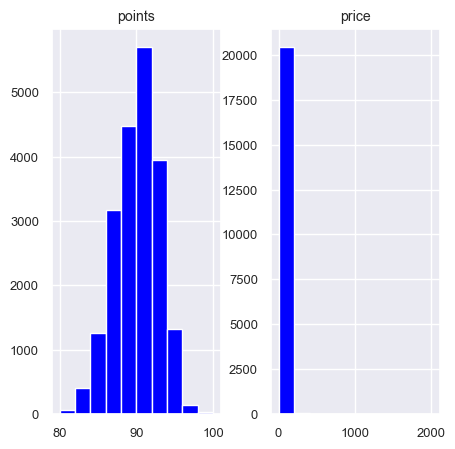

In [16]:
sns.set(font_scale=0.85, rc={'figure.figsize': (5, 5)})
ax = data.hist(color='blue')

In [17]:
std_scaler = StandardScaler()
scaled_features = std_scaler.fit_transform(data[['points', 'price']])
scaled_df = pd.DataFrame(scaled_features, columns=['points', 'price'])
scaled_df

,points,price
0,-0.896096,0.778103
1,-0.896096,-0.754843
2,-0.896096,-0.654868
3,-0.896096,0.911403
4,-1.246295,0.278230
...,...,...
20488,0.504697,2.111100
20489,0.504697,-0.021695
20490,0.154499,-0.721518
20491,0.154499,-0.221644


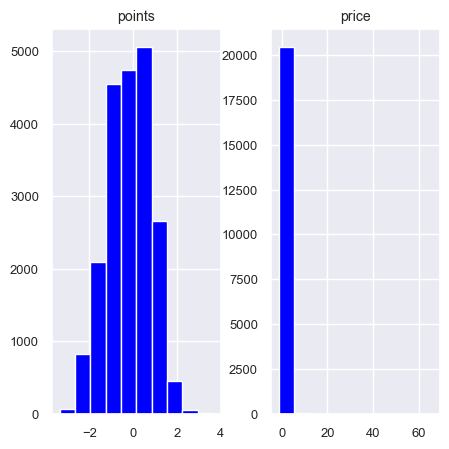

In [18]:
ax = scaled_df.hist(color='blue')

In [19]:
vec_df = vec_df.join(scaled_df, how='left')
vec_df.head()

,v1,v2,v3,v4,v5,w1,w2,w3,w4,w5,province,region_1,region_2,variety,points,price
0,0.258066,0.142488,-0.248683,-0.212466,-0.425514,0.258066,0.142488,-0.248683,-0.212466,-0.425514,2,172,172,111,-0.896096,0.778103
1,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0.178039,-0.147525,0.108014,-0.540345,-0.432309,0,86,81,19,-0.896096,-0.754843
2,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0.539413,-0.323074,0.482881,-0.569893,-0.200204,0,100,21,74,-0.896096,-0.654868
3,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0.210961,-0.258978,0.014871,-0.358774,-0.023853,0,139,138,111,-0.896096,0.911403
4,0.280273,0.042108,-0.034135,-0.111508,-0.051829,0.280273,0.042108,-0.034135,-0.111508,-0.051829,2,70,172,111,-1.246295,0.278230


### Удаление неинформативных колонок
Кажется, некоторые колонки (такие, как имя автора отзыва и его ник в твиттере) не несут никакой значимой информации о вине как таковом. Если мы хотим кластеризовать сами вина, а не авторов, то эти колонки можно спокойно выбросить. Дальше будем работать с датафреймом vec_df, в котором некоторых из исходных колонок нет:

In [20]:
vec_df.shape

(20493, 16)

In [21]:
vec_df.nunique()

v1          20490
v2          20493
v3          20490
v4          20486
v5          20478
w1          20490
w2          20493
w3          20490
w4          20486
w5          20478
province        4
region_1      171
region_2       17
variety       183
points         21
price         146
dtype: int64

Посмотрим на корреляцию числовых параметров -- цены и рейтинга:

In [22]:
corr_df = vec_df[['points', 'price']]
corr_df.corr()

,points,price
points,1.000000,0.394538
price,0.394538,1.000000


Тут мы видим слабую положительную корреляцию: чем дороже вино, тем лучше его оценивают.

### Уменьшение размерности

In [23]:
pca_2 = PCA(2)
pca_2_result = pca_2.fit_transform(vec_df) 
pca_2_result.shape

(20493, 2)

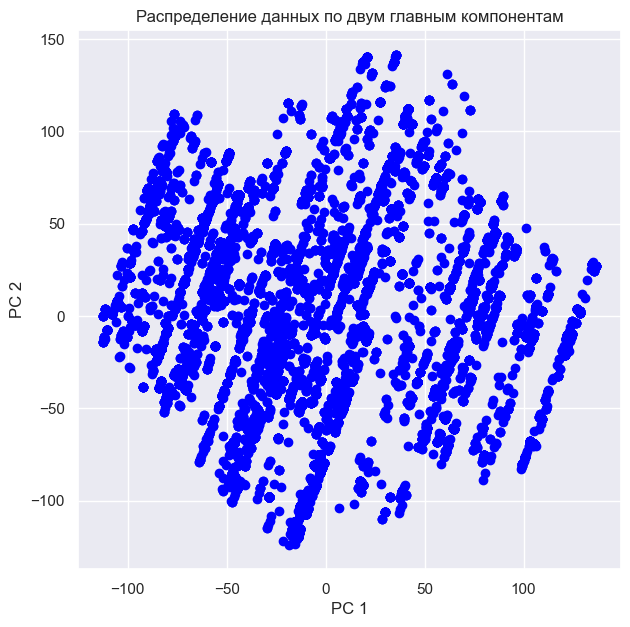

In [24]:
sns.set(rc={'figure.figsize': (7, 7)}, font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Картинка подсказывает, что хорошей кластеризации не получится)) Можно попробовать еще почистить датасет, например, кластеризовать по типам вина, выбрав только самые частотные.

In [26]:
Counter(vec_df['variety'].tolist()).most_common(30)

[(111, 4398),
 (32, 2191),
 (19, 2179),
 (117, 1662),
 (142, 1540),
 (181, 1025),
 (13, 1017),
 (74, 541),
 (132, 521),
 (118, 463),
 (120, 463),
 (123, 324),
 (179, 303),
 (140, 279),
 (16, 260),
 (55, 258),
 (66, 253),
 (108, 251),
 (175, 246),
 (101, 212),
 (127, 148),
 (156, 142),
 (119, 141),
 (85, 106),
 (52, 89),
 (9, 88),
 (100, 80),
 (47, 74),
 (73, 60),
 (36, 53)]

In [27]:
common_wines = [wine[0] for wine in Counter(vec_df['variety'].tolist()).most_common(30)
                if wine[-1] >= 100]
len(common_wines)

24

In [28]:
vec_df_cut = vec_df[vec_df['variety'].isin(common_wines)]
vec_df_cut.shape

(18923, 16)

In [29]:
pca_cut = PCA(2)
pca_cut_result = pca_cut.fit_transform(vec_df_cut) 
pca_cut_result.shape

(18923, 2)

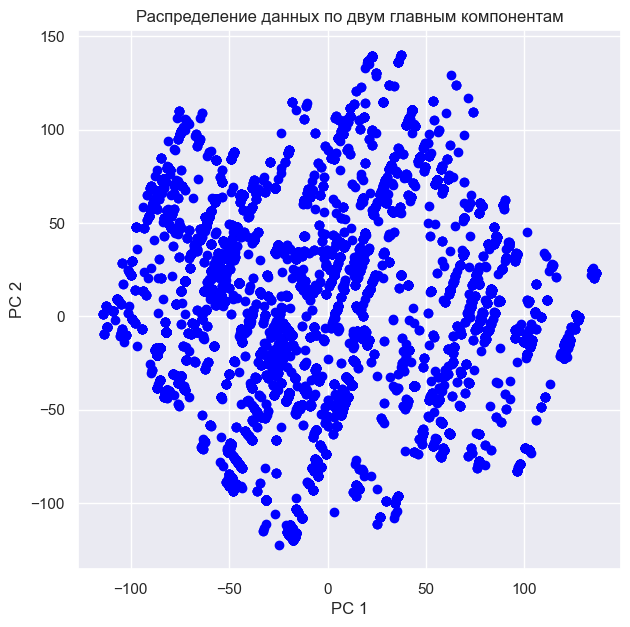

In [30]:
plt.scatter(x=pca_cut_result[:, 0], y=pca_cut_result[:, 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Лучше ожидаемо не стало. Попробуем кластеризовать, как есть.

## Кластеризация
В идеальном мире хотелось бы увидеть разделение датасета на кластеры по типам вина или регионам, но мы уже поняли, что это утопия. Провинции и регионы вряд ли сильно различаются между собой, а вот типы вина могут. Их в нашем датасете 171, поэтому выберем такое число кластеров.

In [33]:
kmeans = KMeans(n_clusters=171, n_init=15, random_state=RANDOM_SEED)
kmeans.fit(pca_cut_result)

KMeans(n_clusters=171, n_init=15, random_state=42)

Посмотрим на метрики: *инерция* -- сумма квадратов ошибок для каждого кластера. Чем ниже значения инерции, тем более "плотные" получились кластеры, следовательно, тем лучше прошла кластеризация.

In [34]:
kmeans.inertia_

145240.7449053894

Значение инерции очень большое, следовательно, кластеризация плохая *(хотя до этого я кластеризовала без фильтрации датасета, и было еще хуже...)*.

Попробуем кластеризацию по разным значениям (по числу уникальных значений для разных признаков):

In [36]:
num_clusters = sorted([4, 171, 17, 183, 21, 146])

inertia = {}
silhouette = {}

for i in tqdm(num_clusters):
    kmeans = KMeans(n_clusters=i, n_init=15, random_state=RANDOM_SEED)
    kmeans.fit(pca_cut_result)
    inertia[i] = kmeans.inertia_
    silhouette[i] = silhouette_score(pca_cut_result,
                                     kmeans.labels_,
                                     metric='euclidean')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:01<00:00, 10.20s/it]


In [37]:
inertia

{4: 29360395.348541755,
 17: 4945552.322394056,
 21: 3887647.84003641,
 146: 190322.7694969795,
 171: 145240.74490538944,
 183: 127726.94438757109}

Чем больше кластеров, тем меньше значение инерции, но оно все равно очень велико.

Теперь посмотрим на силуэты (чем больше значение, тем лучше).

In [38]:
silhouette

{4: 0.44188946115154154,
 17: 0.5284101931671197,
 21: 0.5271540011373465,
 146: 0.7219303377939089,
 171: 0.7428960415925014,
 183: 0.7474217079348899}

На бОльшем числе кластеров silhouette score выше, но незначительно. Можно было бы сделать, скажем, 300 кластеров, но какому параметру соответствовало бы такое разделение?

### Визуализация: метрики

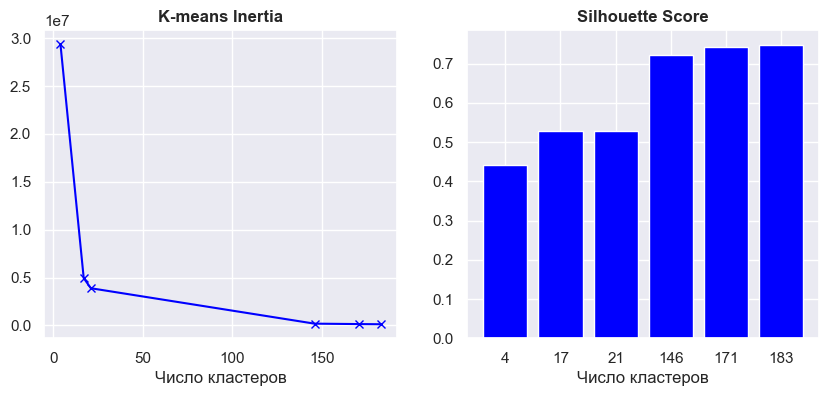

In [39]:
sns.set(font_scale=1, rc={'figure.figsize': (10, 4)})

# значения инерции
plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index
plt.plot(list(inertia.keys()), list(inertia.values()), marker='x', color='blue') 
plt.title('K-means Inertia', fontweight='bold')
plt.xlabel('Число кластеров')
plt.grid(True)

# силуэты
plt.subplot(1, 2, 2)
plt.bar(range(len(silhouette)),
        list(silhouette.values()),
        align='center', color='blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Число кластеров')
plt.grid(True)

plt.show()

Наше лучшее число кластеров -- 183.

In [40]:
kmeans = KMeans(n_clusters=183, n_init=15, random_state=RANDOM_SEED)
kmeans_labels = kmeans.fit_predict(pca_cut_result)
centroids = kmeans.cluster_centers_
display(pd.Series(kmeans_labels).value_counts())

146    845
9      666
8      629
17     474
23     403
      ... 
111     12
116     10
15       9
93       9
165      8
Length: 183, dtype: int64

In [41]:
pca_cut_df = pd.DataFrame(pca_cut_result)
pca_cut_df['kmeans'] = kmeans_labels

In [42]:
pca_cut_df

,0,1,kmeans
0,120.642941,-20.543665,146
1,-19.641013,-41.230627,60
2,-49.898582,-31.010222,105
3,75.742864,-5.434750,17
4,69.438549,52.854549,38
...,...,...,...
18918,-62.584030,46.587956,9
18919,4.685376,-49.841160,98
18920,10.463864,-33.678868,53
18921,-16.633586,-32.833912,101


### Визуализация: кластеры

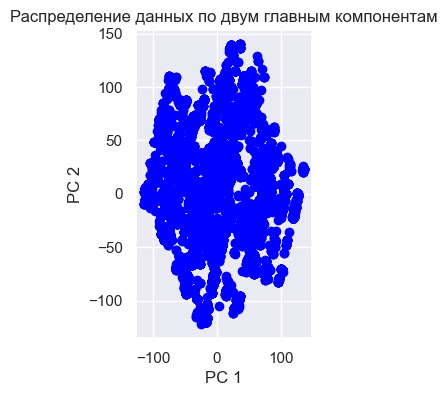

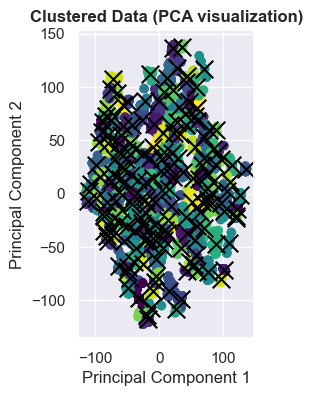

In [43]:
sns.set(rc={'figure.figsize': (5, 4)}, font_scale=1)

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index
plt.scatter(x=pca_cut_result[:, 0], y=pca_cut_result[:, 1],
            color='blue') # 0 и 1 - индексы колонок
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

plt.subplot(1, 2, 2)
sns.set(rc={'figure.figsize': (5, 4)}, font_scale=1)

plt.scatter(x=pca_cut_result[:, 0], y=pca_cut_result[:, 1],
            c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('Clustered Data (PCA visualization)', fontweight='bold')

plt.show()

Осталось посчитать метрики, хотя и без них понятно, что все как-то не очень:

In [44]:
# силуэты: определяется на промежутке [-1;1] (чем выше тем лучше)
# инерция: определяется на [0, inf) (чем ниже тем лучше)

print('Inertia score: %0.1f' % kmeans.inertia_)
print('Silhouette score: %0.1f' % silhouette_score(pca_cut_result,
                                                   kmeans.labels_,
                                                   metric='euclidean'))

Inertia score: 127726.9
Silhouette score: 0.7


Кластеры получились плохие :(

### Mean Shift
Интересно попробовать, потому что этот алгоритм не распихивает все объекты по кластерам, даже если они туда не лезут.

In [45]:
# bandwidth - как раз размер этого кружка, но его сложно подбирать самому, т.к. в каждой задаче он будет свой
# вот так можно узнать, что будет по умолчанию и начать с этого значения, постепенно уменьшая или увеличивая

sklearn.cluster.estimate_bandwidth(vec_df_cut)

103.5791531961997

In [46]:
cluster = MeanShift(cluster_all=False, bandwidth=103)
cluster.fit(vec_df_cut)

MeanShift(bandwidth=103, cluster_all=False)

In [47]:
len(set(cluster.labels_))

2

In [48]:
vec_df_cut['mean_shift'] = cluster.labels_
vec_df_cut['mean_shift'].value_counts() 

C:\Users\Елизавета Клыкова\AppData\Local\Temp\ipykernel_25004\3740892851.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vec_df_cut['mean_shift'] = cluster.labels_


 0    12781
-1     6142
Name: mean_shift, dtype: int64

Ну это, конечно, просто восторг: данные распределились на кластер мусора и не-мусора))

In [49]:
# print('Inertia score: %0.1f' % cluster.inertia_)
print('Silhouette score: %0.1f' % silhouette_score(vec_df_cut.drop(columns=['mean_shift']),
                                                   cluster.labels_,
                                                   metric='euclidean'))

Silhouette score: 0.2


И метрика, конечно, тоже плохая.

In [50]:
vec_df_cut.drop(columns=['mean_shift'], inplace=True)

C:\Users\Елизавета Клыкова\AppData\Local\Temp\ipykernel_25004\1721454840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vec_df_cut.drop(columns=['mean_shift'], inplace=True)


### DBSCAN

In [51]:
# eps - задает максимальную для объединения дистанцию между объектами == размер окрестности
# min_samples - минимальное количество объектов в классе

cluster = DBSCAN(min_samples=5, eps=0.5)
cluster.fit(vec_df_cut)

DBSCAN()

Метки кластеров для всех объектов в датасете лежат в cluster.labels_

In [52]:
vec_df_cut['dbscan'] = cluster.labels_
vec_df_cut['dbscan'].value_counts() 

C:\Users\Елизавета Клыкова\AppData\Local\Temp\ipykernel_25004\4030774996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vec_df_cut['dbscan'] = cluster.labels_


-1      15468
 1        581
 0        403
 5        208
 13       201
        ...  
 101        4
 113        3
 69         3
 108        3
 58         2
Name: dbscan, Length: 117, dtype: int64

In [53]:
print('Silhouette score: %0.3f' % silhouette_score(vec_df_cut.drop(columns=['dbscan']),
                                                   cluster.labels_,
                                                   metric='euclidean'))

Silhouette score: -0.655


:(

In [54]:
vec_df_cut.drop(columns=['dbscan'], inplace=True)

C:\Users\Елизавета Клыкова\AppData\Local\Temp\ipykernel_25004\4064535278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vec_df_cut.drop(columns=['dbscan'], inplace=True)


## Результаты

Кластеризация всеми методами получилась плохая. Скорее всего, это просто особенность датасета и задачи: какая-нибудь регрессия или классификация вполне могла бы получиться (например, предсказание оценки или цены по описанию), но кластеризоваться данные не хотят из-за своей разнородности. Если бы у нас были какие-нибудь данные о составе вин, как в датасете на паре, то вина могли бы кластеризоваться по типам.

Чем большее число кластеров мы задавали, тем лучше кластеризовались данные (по крайней мере, для K-Means это было очевидно). Возможно, данные можно было бы разбить на много-много мелких кластеров, но визуализировать и анализировать их глазами было бы нереально. Кроме того, непонятно, как можно было бы интерпретировать такое число кластеров: может быть, как вина, произведенные на одной винодельне? Для таких выводов нужно обладать некоторым уровнем знаний по данной теме, которого лично у меня нет.

## Попытки исправить ситуацию
Попробуем взять только описания и сорта вин из исходного датафрейма и сделать кластеризацию по ним.

In [2]:
wine_df = pd.read_csv('winemag-data-130k-v2.csv')
wine_df.drop(columns=['Unnamed: 0'], inplace=True)
wine_df.drop_duplicates(inplace=True)

wine_df = wine_df[['description', 'variety']]
wine_df.dropna(inplace=True)
wine_df.shape

(119987, 2)

In [3]:
wine_df['variety'].value_counts()

Pinot Noir                    12278
Chardonnay                    10868
Cabernet Sauvignon             8840
Red Blend                      8243
Bordeaux-style Red Blend       6471
                              ...  
Cabernet Sauvignon-Barbera        1
Merlot-Shiraz                     1
Folle Blanche                     1
Forcallà                          1
Bobal-Cabernet Sauvignon          1
Name: variety, Length: 707, dtype: int64

In [4]:
common_wines = Counter(wine_df['variety'].tolist())
common_wines.most_common(30)

[('Pinot Noir', 12278),
 ('Chardonnay', 10868),
 ('Cabernet Sauvignon', 8840),
 ('Red Blend', 8243),
 ('Bordeaux-style Red Blend', 6471),
 ('Riesling', 4773),
 ('Sauvignon Blanc', 4575),
 ('Syrah', 3828),
 ('Rosé', 3220),
 ('Merlot', 2896),
 ('Nebbiolo', 2607),
 ('Zinfandel', 2530),
 ('Sangiovese', 2462),
 ('Malbec', 2446),
 ('Portuguese Red', 2282),
 ('White Blend', 2179),
 ('Sparkling Blend', 1971),
 ('Tempranillo', 1671),
 ('Rhône-style Red Blend', 1343),
 ('Pinot Gris', 1324),
 ('Champagne Blend', 1308),
 ('Cabernet Franc', 1243),
 ('Grüner Veltliner', 1201),
 ('Portuguese White', 1057),
 ('Bordeaux-style White Blend', 993),
 ('Pinot Grigio', 980),
 ('Gewürztraminer', 940),
 ('Gamay', 926),
 ('Viognier', 922),
 ('Shiraz', 790)]

Возьмем только те виды, которые встретились больше 1000 раз.

In [5]:
common_1000 = [wine[0] for wine in common_wines.most_common(30)
               if wine[1] >= 1000]
common_1000

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot',
 'Nebbiolo',
 'Zinfandel',
 'Sangiovese',
 'Malbec',
 'Portuguese Red',
 'White Blend',
 'Sparkling Blend',
 'Tempranillo',
 'Rhône-style Red Blend',
 'Pinot Gris',
 'Champagne Blend',
 'Cabernet Franc',
 'Grüner Veltliner',
 'Portuguese White']

In [11]:
len(common_1000)

24

In [6]:
wine_df = wine_df[wine_df['variety'].isin(common_1000)]
wine_df.shape

(91616, 2)

In [7]:
descs = [text.lower().split() for text in wine_df['description'].tolist()]
tagged_descs = [TaggedDocument(doc, [i]) for i, doc in enumerate(descs)]

In [10]:
model2 = Doc2Vec(tagged_descs, vector_size=5, window=2,
                 min_count=2, workers=4, seed=RANDOM_SEED)

In [12]:
vec_descs = [list(model2.dv[x.tags][0]) for x in tagged_descs]
wine_vec = pd.DataFrame(vec_descs, columns=['v1', 'v2', 'v3', 'v4', 'v5'])

In [17]:
pca = PCA(2)
wine_pca = pca.fit_transform(wine_vec)

Кластеризуем по числу самых популярных разновидностей вина (24):

In [19]:
kmeans = KMeans(n_clusters=24, n_init=15, random_state=RANDOM_SEED)
labels = kmeans.fit_predict(wine_pca)

In [20]:
kmeans.inertia_

631.1826782226562

In [21]:
silhouette_score(wine_pca, kmeans.labels_, metric='euclidean')

0.313158

Инерция стала заметно меньше, что не может не радовать. Попробуем визуализировать получившееся.

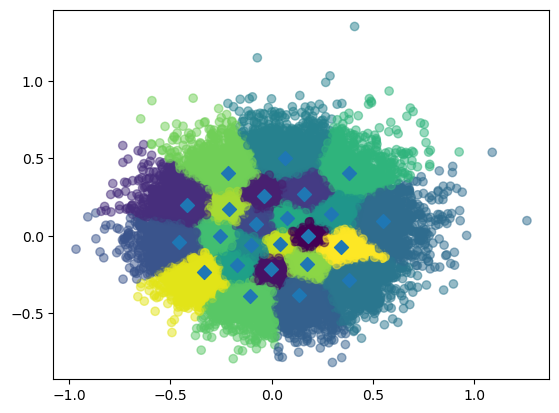

In [22]:
xs = wine_pca[:,0]
ys = wine_pca[:,1]
plt.scatter(xs, ys, c=labels, alpha=0.5)
centroids = kmeans.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]
plt.scatter(centroids_x, centroids_y, marker='D', s=50)
plt.show()

Картинка красивая, а вот сама кластеризация, кажется, не очень...

In [29]:
wine_pca = pd.DataFrame(wine_pca)
wine_pca['variety'] = wine_df['variety']
wine_pca['cluster'] = labels
wine_pca.head()

,0,1,variety,cluster
0,-0.251330,-0.012763,White Blend,16
1,0.460621,-0.047616,Portuguese Red,23
2,-0.246599,-0.070021,Pinot Gris,16
3,-0.180723,-0.234178,Riesling,13
4,0.357773,0.035371,Pinot Noir,23


In [30]:
wine_pca.groupby(['cluster'])['variety'].agg(pd.Series.mode)

cluster
0     Pinot Noir
1     Pinot Noir
2     Pinot Noir
3     Pinot Noir
4     Pinot Noir
5     Pinot Noir
6     Pinot Noir
7     Pinot Noir
8     Pinot Noir
9     Pinot Noir
10    Pinot Noir
11    Pinot Noir
12    Pinot Noir
13    Pinot Noir
14    Pinot Noir
15    Pinot Noir
16    Pinot Noir
17    Pinot Noir
18    Chardonnay
19    Pinot Noir
20    Pinot Noir
21    Pinot Noir
22    Pinot Noir
23    Pinot Noir
Name: variety, dtype: object

К сожалению, это не помогло :( Самый распространенный сорт вина расползся по всем кластерам вместо того, чтобы группироваться в один. Возможно, это связано с векторизацией текстов Doc2Vec, и стоило использовать TfIdf, придающий бОльший вес наиболее отличающимся терминам. Еще можно было бы включить данные об авторах описаний и посмотреть, не кластеризуются ли они в разные группы (как в стилометрических исследованиях), но я больше не могу думать про вина и машинное обучение.....